In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [26]:
#Libraries needed for plotting graphs
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

import pandas as pd

%matplotlib inline
rcParams['figure.figsize'] = 20, 20
plt.style.use('seaborn-whitegrid')

In [3]:
#Initialise the SparkSeesion

spark = SparkSession \
.builder \
.appName("customer churn example") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()

# Load and parse the data file, converting it to a DataFrame.
trainData = spark.read.load('churn-train.csv',format="csv",inferschema=True, header=True)
testData = spark.read.load('churn-test.csv',format="csv",inferschema=True, header=True)

In [4]:
#Index the label
indexer = StringIndexer(inputCol="label", outputCol="indLabel")
trainData = indexer.fit(trainData).transform(trainData)

In [5]:
#converting the spark dataframe into pandas df
trainPD = trainData.toPandas()

In [6]:
#Finding the correlation matrix

corr = trainPD.corr()
corr

,acclen,arcode,nummailmes,tdmin,tdcal,tdchar,temin,tecal,tecahr,tnmin,tncal,tnchar,timin,tical,tichar,ncsc,indLabel
acclen,1.000000,-0.012463,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796,0.016541
arcode,-0.012463,1.000000,-0.001994,-0.008264,-0.009646,-0.008264,0.003580,-0.011886,0.003607,-0.005825,0.016522,-0.005845,-0.018288,-0.024179,-0.018395,0.027572,0.006174
nummailmes,-0.004628,-0.001994,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263,-0.089728
tdmin,0.006216,-0.008264,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423,0.205151
tdcal,0.038470,-0.009646,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942,0.018459
tdchar,0.006214,-0.008264,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427,0.205151
temin,-0.006757,0.003580,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985,0.092796
tecal,0.019260,-0.011886,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423,0.009233
tecahr,-0.006745,0.003607,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987,0.092786
tnmin,-0.008955,-0.005825,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288,0.035493


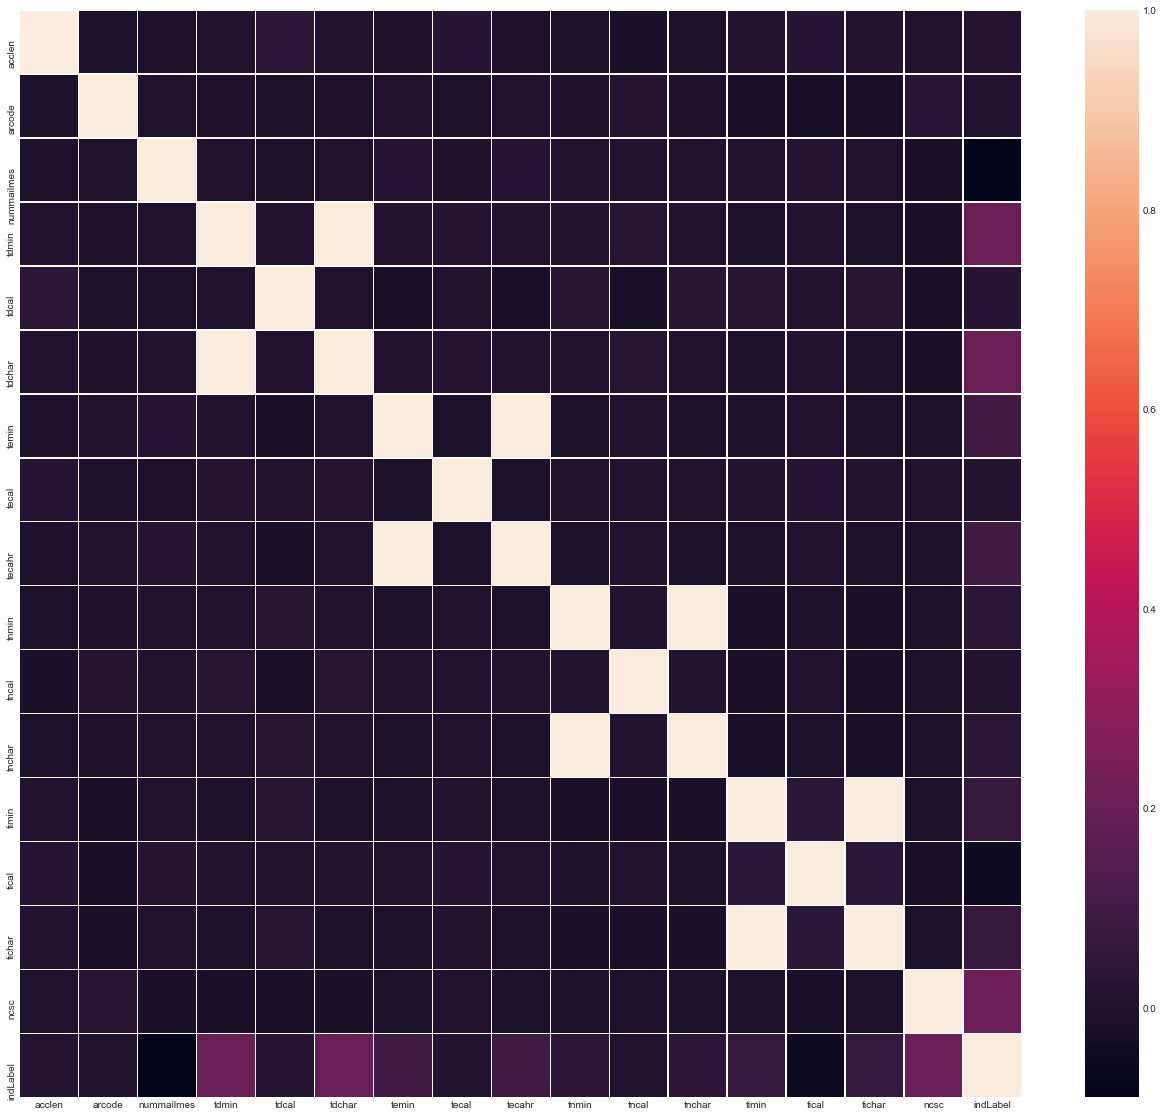

In [27]:
#plotting the heat-map

sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values,linewidths=0.5)

Text(0,0.5,'Total Daily Time charges')

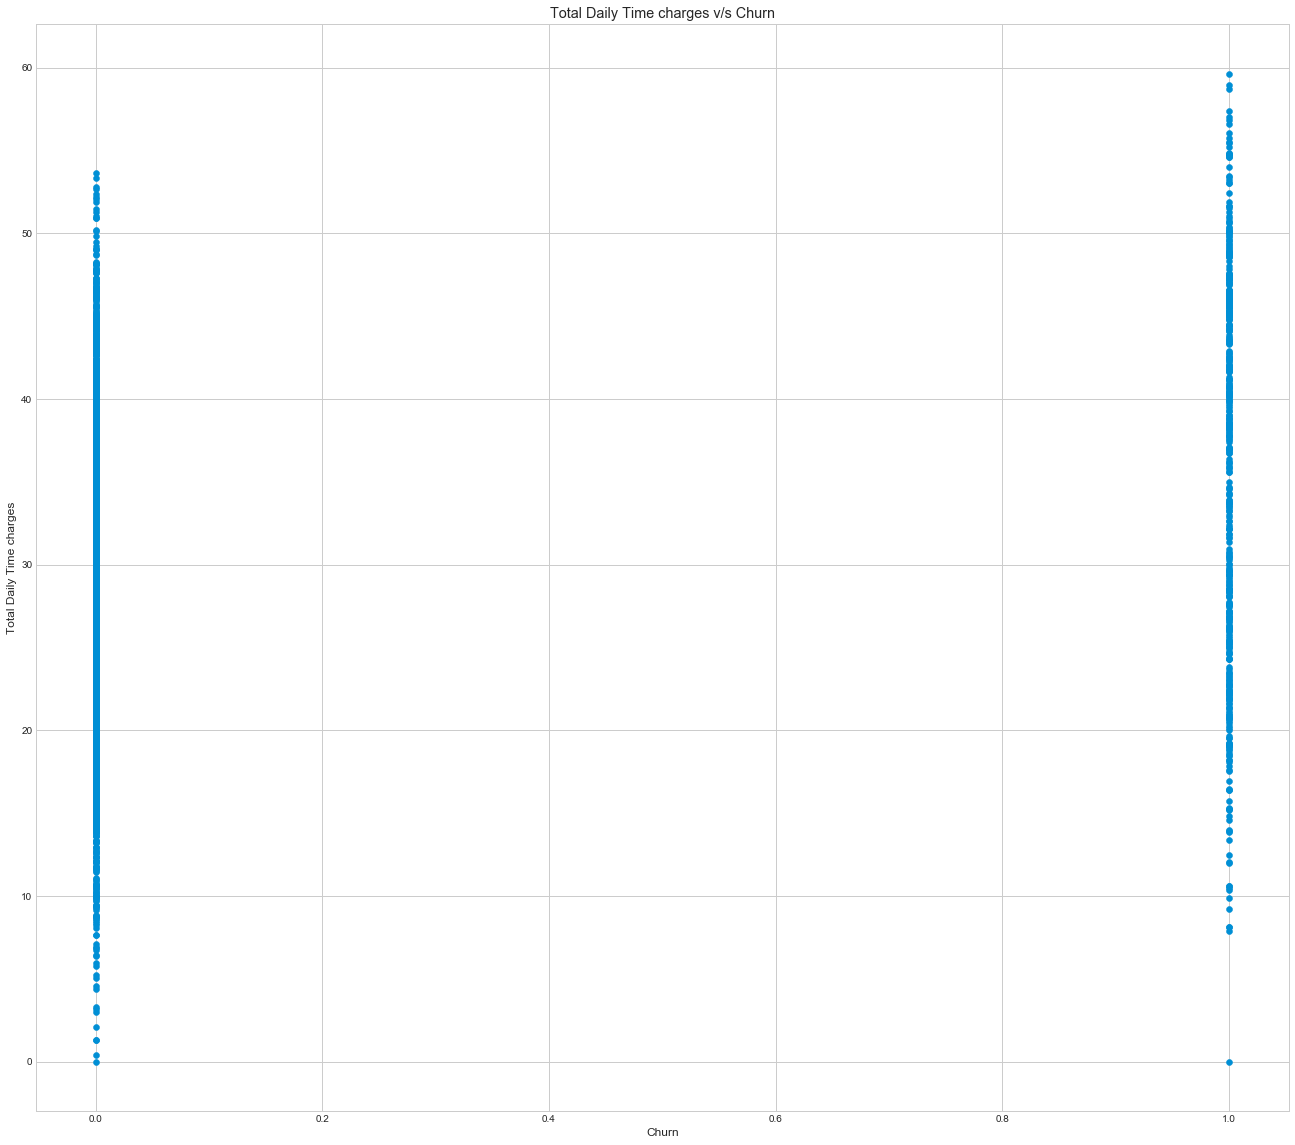

In [28]:
x = trainPD['indLabel']
y = trainPD['tdchar']
 
# Create scatter plot
plt.scatter(x, y)
 
# Add title and axis names
plt.title('Total Daily Time charges v/s Churn')
plt.xlabel('Churn')
plt.ylabel('Total Daily Time charges')

Text(0,0.5,'Number of Customer service calls')

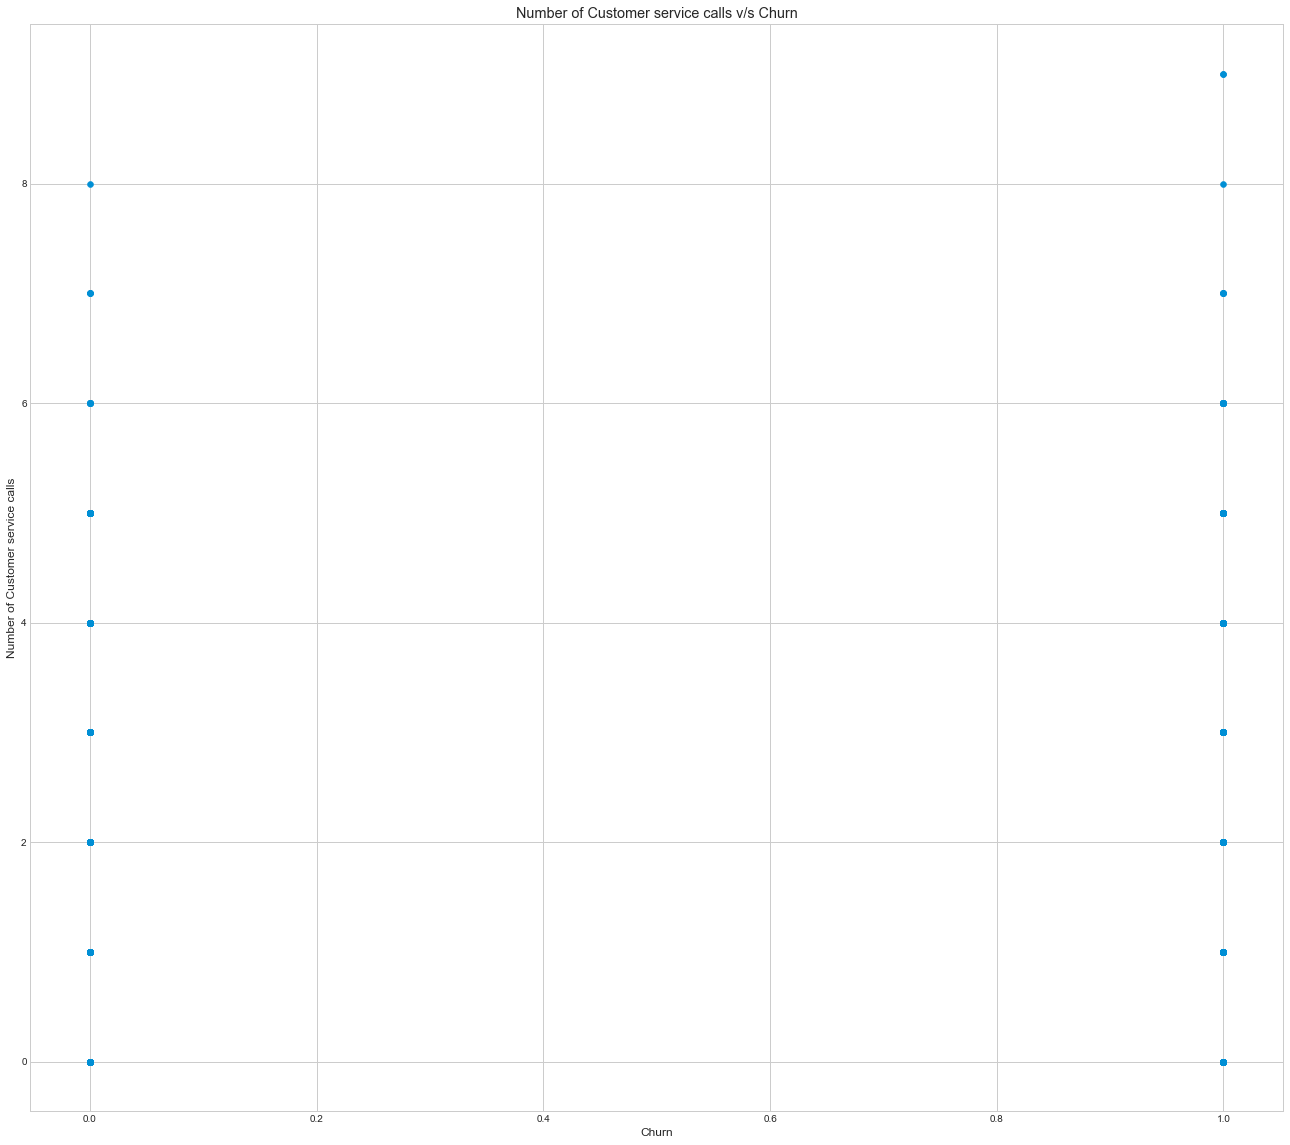

In [29]:
x = trainPD['indLabel']
y = trainPD['ncsc']
 
# Create scatter plot
plt.scatter(x, y)
 
# Add title and axis names
plt.title('Number of Customer service calls v/s Churn')
plt.xlabel('Churn')
plt.ylabel('Number of Customer service calls')

In [10]:
#assemble the features in one column = features for training data
vectorAss = VectorAssembler(inputCols=["acclen",
                                       "arcode",
                                       "nummailmes",
                                       "tdmin",
                                      "tdcal","tdchar","temin",
                                      "tecal","tecahr","tnmin",
                                      "tncal","tnchar","timin","tical","tichar",
                                      "ncsc"]
                            ,outputCol="features")

trainData = vectorAss.transform(trainData)

#assemble the features in one column = features for testing data
testData = vectorAss.transform(testData)

In [11]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(trainData)

In [12]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(trainData)

In [13]:
#Train a gbt model
gbt = GBTClassifier(labelCol="indexedLabel",featuresCol="indexedFeatures",maxIter=7)

In [14]:
data = featureIndexer.transform(trainData)
data = labelIndexer.transform(data)

testData = featureIndexer.transform(testData)
testData = labelIndexer.transform(testData)

# Train model.  This also runs the indexers.
model = gbt.fit(data)

In [15]:
# Make predictions.
predictions = model.transform(testData)

In [16]:
# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|[101.0,510.0,0.0,...|
|       1.0|         0.0|[137.0,510.0,0.0,...|
|       0.0|         0.0|[103.0,408.0,29.0...|
|       0.0|         0.0|[99.0,415.0,0.0,2...|
|       0.0|         0.0|[108.0,415.0,0.0,...|
+----------+------------+--------------------+
only showing top 5 rows



In [17]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g" % (accuracy))

Test Error = 0.0785843
Accuracy = 0.921416


In [18]:
tp = predictions[(predictions.indexedLabel == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.indexedLabel == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.indexedLabel == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.indexedLabel == 1) & (predictions.prediction == 0)].count()
print ("True Positives:", tp)
print ("True Negatives:", tn)
print ("False Positives:", fp)
print ("False Negatives:", fn)
print ("Total", predictions.count())

r = float(tp)/(tp + fn)
print ("recall", r)

p = float(tp) / (tp + fn)
print ("precision - true", p)

p1 = float(tn) / (tn + fp)
print ("precision - false", p1)

True Positives: 115
True Negatives: 1421
False Positives: 22
False Negatives: 109
Total 1667
recall 0.5133928571428571
precision - true 0.5133928571428571
precision - false 0.9847539847539848


In [19]:
trainData.printSchema()

root
 |-- st: string (nullable = true)
 |-- acclen: integer (nullable = true)
 |-- arcode: integer (nullable = true)
 |-- phnum: string (nullable = true)
 |-- intplan: string (nullable = true)
 |-- voice: string (nullable = true)
 |-- nummailmes: integer (nullable = true)
 |-- tdmin: double (nullable = true)
 |-- tdcal: integer (nullable = true)
 |-- tdchar: double (nullable = true)
 |-- temin: double (nullable = true)
 |-- tecal: integer (nullable = true)
 |-- tecahr: double (nullable = true)
 |-- tnmin: double (nullable = true)
 |-- tncal: integer (nullable = true)
 |-- tnchar: double (nullable = true)
 |-- timin: double (nullable = true)
 |-- tical: integer (nullable = true)
 |-- tichar: double (nullable = true)
 |-- ncsc: integer (nullable = true)
 |-- label: string (nullable = true)
 |-- indLabel: double (nullable = false)
 |-- features: vector (nullable = true)



In [20]:
feature_list = list(trainData.columns)
feature_list.remove('indLabel')
feature_list.remove('label')
feature_list.remove('features')
feature_list.remove('st')
feature_list.remove('phnum')
feature_list.remove('intplan')
feature_list.remove('voice')
feature_list

['acclen',
 'arcode',
 'nummailmes',
 'tdmin',
 'tdcal',
 'tdchar',
 'temin',
 'tecal',
 'tecahr',
 'tnmin',
 'tncal',
 'tnchar',
 'timin',
 'tical',
 'tichar',
 'ncsc']

In [21]:
# Get numerical feature importances
importances = list(model.featureImportances)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: tdmin                Importance: 0.28
Variable: temin                Importance: 0.19
Variable: tnmin                Importance: 0.11
Variable: ncsc                 Importance: 0.1
Variable: nummailmes           Importance: 0.09
Variable: timin                Importance: 0.07
Variable: tical                Importance: 0.05
Variable: acclen               Importance: 0.04
Variable: tdcal                Importance: 0.03
Variable: tncal                Importance: 0.02
Variable: arcode               Importance: 0.01
Variable: tecal                Importance: 0.01
Variable: tnchar               Importance: 0.01
Variable: tdchar               Importance: 0.0
Variable: tecahr               Importance: 0.0
Variable: tichar               Importance: 0.0


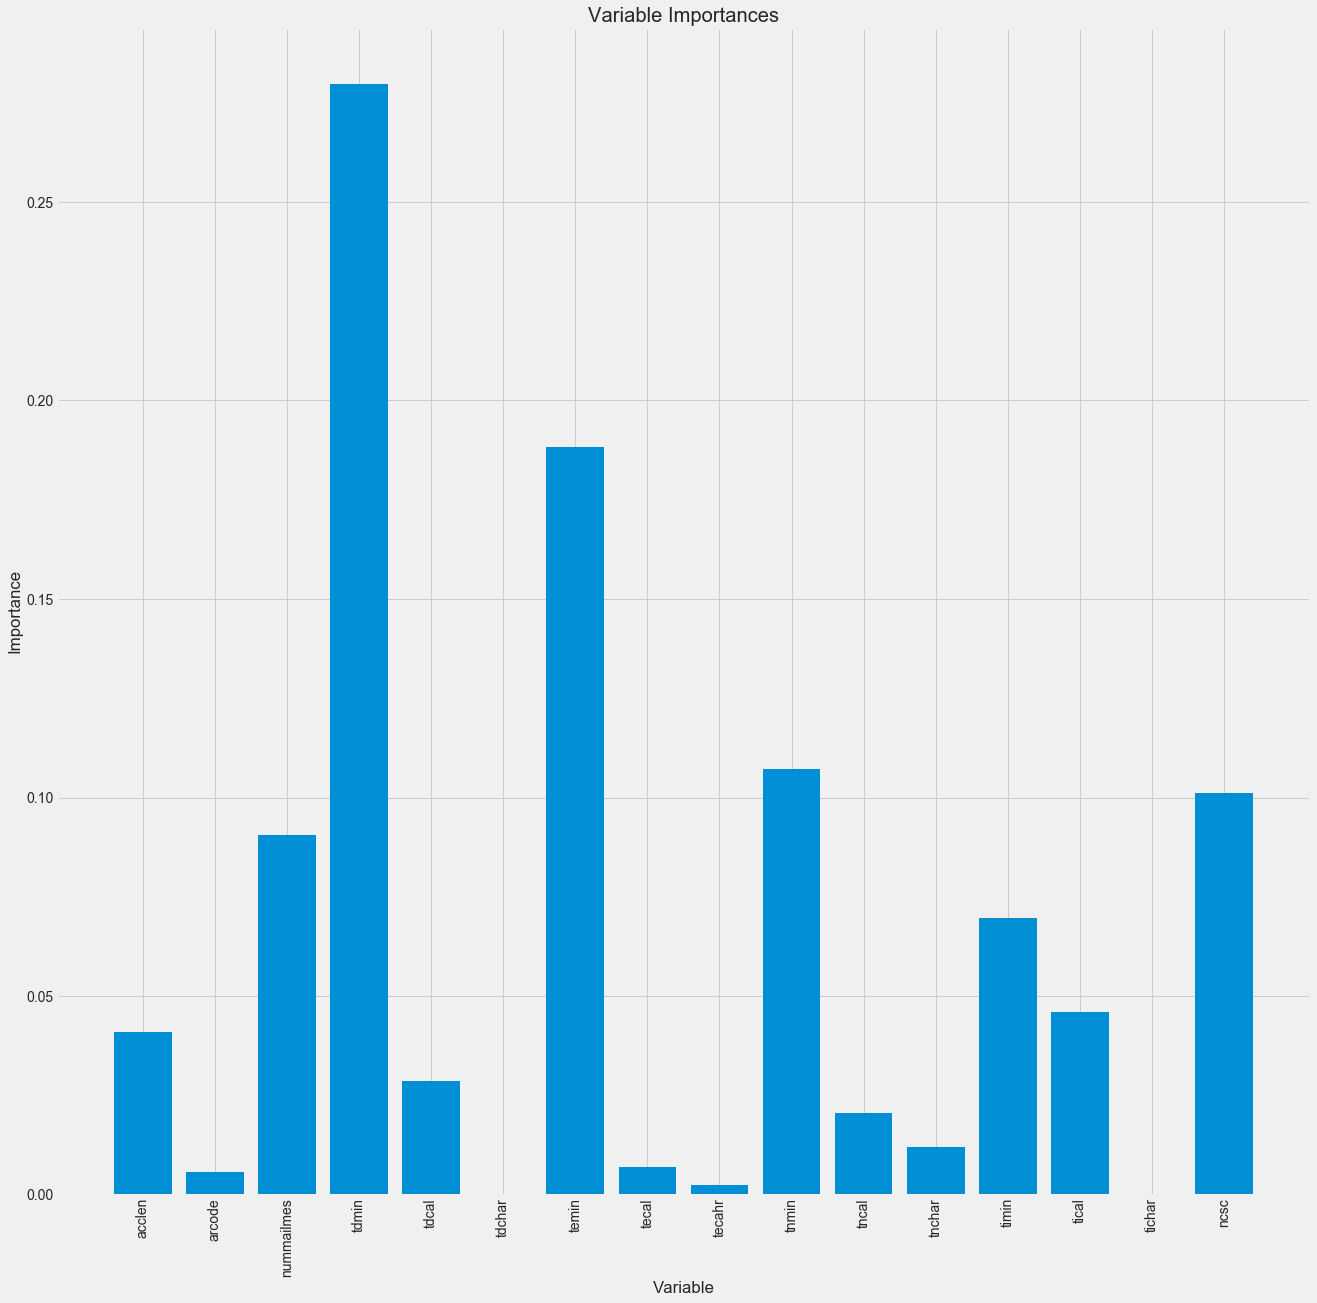

In [30]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');